In [1]:
#Necessary Imports
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
#os.system("pip freeze > requirements.txt")
#os.system("pip install -r requirements.txt")
os.system("pip install umap-learn")
os.system("pip install mplhep")
os.system("pip install psycopg2-binary --user")

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
from io import BytesIO
from PIL import Image
import base64
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
import dask.array as da

import tensorflow as tf
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
from umap.parametric_umap import ParametricUMAP as PUMAP
from sklearn.decomposition import PCA
import sys
os.system("pip show psycopg2-binary")
sys.path.append("/home/jovyan/.local/lib/python3.11/site-packages")

import io
import psycopg2
import subprocess
import pickle
# Import necessary libraries
from matplotlib.legend import Legend
from sklearn.metrics import auc as auc
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, TensorBoard
from keras.layers import Lambda, Concatenate
import datetime

2025-02-03 19:19:56.284505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Name: psycopg2-binary
Version: 2.9.10
Summary: psycopg2 - Python-PostgreSQL Database Adapter
Home-page: https://psycopg.org/
Author: Federico Di Gregorio
Author-email: fog@initd.org
License: LGPL with exceptions
Location: /home/jovyan/.local/lib/python3.11/site-packages
Requires: 
Required-by: 


In [2]:
# Define a function to replace NaN values with the column median
def replace_nan_with_median(data):
    """Replaces NaN values in each column with the median of the non-NaN values."""
    for col in range(data.shape[1]):  # Iterate over columns
        col_data = data[:, col]
        # Compute the median of non-NaN values
        non_nan_values = col_data[~np.isnan(col_data)]
        if non_nan_values.size > 0:
            median_value = np.median(non_nan_values)
            # Replace NaN values with the median
            col_data[np.isnan(col_data)] = median_value
        else:
            # If all values are NaN, fill with 0 or a default value
            col_data[np.isnan(col_data)] = 0
    return data

# Function to query in batches and collect data
def fetch_data_in_batches(cursor, table_name, id_column, id_list, batch_size=10000):
    data = []
    for i in range(0, len(id_list), batch_size):
        # Extract the current batch of IDs
        batch = id_list[i:i + batch_size]
        batch_str = ', '.join(map(str, batch))
        
        # Execute the query for the current batch
        query = f"SELECT * FROM {table_name} WHERE {id_column} IN ({batch_str})"
        print("Query: " + str(i))
        cursor.execute(query)
        
        # Fetch and extend the data list
        data.extend(cursor.fetchall())
    return replace_nan_with_median(np.array(data, dtype=float))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mse_loss(inputs, outputs):
    #Mean distance squared between input and output tensors
    return tf.math.reduce_mean((inputs - outputs) ** 2, axis=-1)

# def make_mse_per_sample(inputs, outputs):
#     outputs = tf.cast(outputs, dtype=inputs.dtype)  # make same type

#     inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
#     outputs = tf.reshape(outputs, [-1, (nmet + nele + nmu + njet), nfeat])

#     # extract pt
#     outputs_pt = outputs[:, :, 0]

#     # trick with phi (rescaled tanh activation function)
#     outputs_phi = phi_max * tf.math.tanh(outputs[:, :, 2])

#     # trick with eta (rescaled tanh activation function)
#     outputs_eta_met = outputs[:, 0:1, 1]
#     outputs_eta_ele = ele_eta_max * tf.math.tanh(
#         outputs[:, ele_off : ele_off + nele, 1]
#     )
#     outputs_eta_mu = mu_eta_max * tf.math.tanh(outputs[:, mu_off : mu_off + nmu, 1])
#     outputs_eta_jet = jet_eta_max * tf.math.tanh(
#         outputs[:, jet_off : jet_off + njet, 1]
#     )
#     outputs_eta = tf.concat(
#         [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
#     )

#     # use both tricks
#     outputs = tf.stack([outputs_pt, outputs_eta, outputs_phi], axis=-1)

#     # mask zero features
#     mask = tf.math.not_equal(inputs, 0)
#     mask = tf.cast(mask, dtype=outputs.dtype)
#     outputs = mask * outputs

#     loss = mse_loss(
#         tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
#         tf.reshape(outputs, [-1, (1 + nele + nmu + njet) * nfeat]),
#     )
#     return loss

def make_mse_per_sample(inputs, outputs):
    outputs = tf.cast(outputs, dtype=inputs.dtype)  # make inputs and outputs same type

    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    outputs = tf.reshape(outputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = outputs[:, :, 0]
    
    # extract class
    outputs_class = outputs[:, :, 3]

    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(outputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = outputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        outputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(outputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        outputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    outputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=outputs.dtype)
    outputs = mask * outputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = mse_loss(
        tf.reshape(inputs, [-1, (nmet + nele + nmu + njet) * nfeat]),
        tf.reshape(outputs, [-1, (nmet + nele + nmu + njet) * nfeat]),
    )
    return loss


def make_mse(inputs, outputs):
    loss = make_mse_per_sample(inputs, outputs)

    loss = tf.math.reduce_mean(loss, axis=0)  # average over batch
    loss = tf.cast(loss, dtype=inputs.dtype)

    return loss


def scale_pt(X, pt_scaler=None):
    pt = X[:, 0::nfeat]
    if pt_scaler is None:
        pt_scaler = StandardScaler()
        pt_scaled = pt_scaler.fit_transform(pt)
    else:
        pt_scaled = pt_scaler.transform(pt)
    X_scaled = np.copy(X)
    X_scaled[:, 0::nfeat] = np.multiply(pt_scaled, pt != 0)
    return X_scaled, pt_scaler

def plot_ROC(method, fpr, tpr, tpr_1em5):
    plt.plot(
        fpr,
        tpr,
        label=f"{method}, AUC={auc(fpr, tpr)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr[tpr_1em5]*100:.3f}%",
    )

def plot_ROC(method, fpr, tpr, tpr_1em5, n_comp):
    plt.plot(
        fpr,
        tpr,
        label=f"{method}-{n_comp}, AUC={auc(fpr, tpr)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr[tpr_1em5]*100:.3f}%",
    )

def get_loss_pumap(X_scaled,inv_transform_data):
    #Extract loss from model predictions using make_mse_per_sample function analyzed above
    return np.array(make_mse_per_sample(X_scaled, inv_transform_data))

def get_loss_pca(X_scaled,inv_transform_data):
    #Extract loss from model predictions using make_mse_per_sample function analyzed above
    return np.array(make_mse_per_sample(X_scaled, inv_transform_data))

def make_mse_per_sample_ae_class(inputs, outputs):
    outputs = tf.cast(outputs, dtype=inputs.dtype)  # make inputs and outputs same type

    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    outputs = tf.reshape(outputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = outputs[:, :, 0]
    
    # extract class
    outputs_class = outputs[:, :, 3]

    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(outputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = outputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        outputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(outputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        outputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    outputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=outputs.dtype)
    outputs = mask * outputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = mse_loss(
        tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
        tf.reshape(outputs, [-1, (1 + nele + nmu + njet) * nfeat]),
    )
    
    return loss

def make_mse_ae(inputs, outputs):
    loss = make_mse_per_sample_ae_class(inputs, outputs)

    loss = tf.math.reduce_mean(loss, axis=0)  # average over batch
    loss = tf.cast(loss, dtype=inputs.dtype)

    return loss

def get_loss_ae(X, X_scaled, model):
    return np.array(make_mse_per_sample_ae_class(X_scaled, model.predict(X, batch_size=1024)))

def make_mse_per_sample_vae_class(inputs, outputs, latent_dimension):
    mainOutputs = tf.cast(outputs[:, latent_dimension:-latent_dimension], dtype=inputs.dtype)  # make inputs and outputs same type
    meanLatentSpaceVector = outputs[:, :latent_dimension]
    logVarVector = outputs[:, -latent_dimension:]
    beta = 0.5
    klDivCoef = (beta) * -0.5
    
    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    mainOutputs = tf.reshape(mainOutputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = mainOutputs[:, :, 0]
    
    # extract class
    outputs_class = mainOutputs[:, :, 3]
    
    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(mainOutputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = mainOutputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        mainOutputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(mainOutputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        mainOutputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    mainOutputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=mainOutputs.dtype)
    mainOutputs = mask * mainOutputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    mse_loss_value = mse_loss(
        tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
        tf.reshape(mainOutputs, [-1, (1 + nele + nmu + njet) * nfeat]),
    )
    
    mse_loss_value = tf.math.reduce_mean(mse_loss_value, axis=0)
    
    kl_divergence = tf.math.multiply(klDivCoef, tf.reduce_sum(1 + logVarVector - tf.square(meanLatentSpaceVector) - tf.exp(logVarVector), axis=-1))
    kl_divergence = tf.math.reduce_mean(kl_divergence, axis=0)
    kl_divergence = tf.cast(kl_divergence, dtype = mse_loss_value.dtype)

    # Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = tf.math.add(tf.math.multiply((1 - beta), mse_loss_value), kl_divergence)
    
    return loss

def make_mse_vae(inputs, outputs):
    global latent_dimension
    loss = make_mse_per_sample_vae_class(inputs, outputs, latent_dimension)

    #loss = tf.math.reduce_mean(loss, axis=0)  # average over batch
    loss = tf.cast(loss, dtype=inputs.dtype)

    return loss

def mod_make_mse_per_sample_vae_class(inputs, outputs, latent_dimension):
    mainOutputs = tf.cast(outputs[:, latent_dimension:-latent_dimension], dtype=inputs.dtype)  # make inputs and outputs same type
    meanLatentSpaceVector = outputs[:, :latent_dimension]
    logVarVector = outputs[:, -latent_dimension:]
    beta = 0.5
    klDivCoef = (beta) * -0.5
    
    #1+4+4+10 = 19 with 3 features of pT, eta, phi which are transverse momentum, pseduorapidity, azimuthal angle
    # as in Main AE paper
    inputs = tf.reshape(inputs, [-1, (nmet + nele + nmu + njet), nfeat])
    mainOutputs = tf.reshape(mainOutputs, [-1, (nmet + nele + nmu + njet), nfeat])

    # extract pt
    outputs_pt = mainOutputs[:, :, 0]
    
    # extract class
    outputs_class = mainOutputs[:, :, 3]
    
    # trick with phi (rescaled tanh activation function) - pi times tanh of azimuthal angle
    outputs_phi = phi_max * tf.math.tanh(mainOutputs[:, :, 2])

    #Extracts missing transverse energy pseudorapidity outputs
    outputs_eta_met = mainOutputs[:, 0:1, 1]

    # trick with eta (rescaled tanh activation function) - max electron pseudorapidity times tanh of pseudorapidity
    outputs_eta_ele = ele_eta_max * tf.math.tanh(
        mainOutputs[:, ele_off : ele_off + nele, 1]
    )

    #Treatment of muon pseudorapidity analogous to that of electron
    outputs_eta_mu = mu_eta_max * tf.math.tanh(mainOutputs[:, mu_off : mu_off + nmu, 1])

    #Treatment of jet pseudorapidity analogous to that of electrons and muons
    outputs_eta_jet = jet_eta_max * tf.math.tanh(
        mainOutputs[:, jet_off : jet_off + njet, 1]
    )

    #Output psuedorapidity is triple with missing transverse eneergy, electron, muon, jet
    outputs_eta = tf.concat(
        [outputs_eta_met, outputs_eta_ele, outputs_eta_mu, outputs_eta_jet], axis=1
    )

    # use both tricks - stacks into standard triple - transvere momenta, pseudorapidity, azimuthal angle
    mainOutputs = tf.stack([outputs_pt, outputs_eta, outputs_phi, outputs_class], axis=-1)

    # mask zero features - Zero Padding after output formation
    mask = tf.math.not_equal(inputs, 0)
    mask = tf.cast(mask, dtype=mainOutputs.dtype)
    mainOutputs = mask * mainOutputs

    #Apply previously defined MSE_loss function 1 - corresponding to nmet
    mse_loss_value = mse_loss(
        tf.reshape(inputs, [-1, (1 + nele + nmu + njet) * nfeat]),
        tf.reshape(mainOutputs, [-1, (1 + nele + nmu + njet) * nfeat]),
    )
    
    #mse_loss_value = tf.math.reduce_mean(mse_loss_value, axis=0)
    
    kl_divergence = tf.math.multiply(klDivCoef, tf.reduce_sum(1 + logVarVector - tf.square(meanLatentSpaceVector) - tf.exp(logVarVector), axis=-1))
    #kl_divergence = tf.math.reduce_mean(kl_divergence, axis=0)
    kl_divergence = tf.cast(kl_divergence, dtype = mse_loss_value.dtype)

    # Apply previously defined MSE_loss function 1 - corresponding to nmet
    loss = tf.math.add(tf.math.multiply((1 - beta), mse_loss_value), kl_divergence)
    
    return loss

def get_loss_vae(X, X_scaled, latent_dimension, model):
    return np.array(mod_make_mse_per_sample_vae_class(X_scaled, model.predict(X, batch_size=1024), latent_dimension))

In [3]:
# def create_umap_encoder(input_dim, n_components):
#     return tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_dim,)),
#         tf.keras.layers.Dense(256, activation="relu"),
#         tf.keras.layers.Dense(128, activation="relu"),
#         tf.keras.layers.Dense(n_components),
#     ])

# def create_umap_decoder(n_components, output_dim):
#     return tf.keras.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(n_components,)),
#         tf.keras.layers.Dense(128, activation="relu"),
#         tf.keras.layers.Dense(256, activation="relu"),
#         tf.keras.layers.Dense(output_dim),
#     ])

# def PUMAP_ROC(signal_data, n_comp):
#     # Define the model
#     #, parametric_reconstruction=True, autoencoder_loss=True
#     input_dim = X_train_scaled.shape[1]  # Get the input feature dimension
#     output_dim = input_dim  # Decoder output should match input dim

#     # Define encoder and decoder
#     encoder = create_umap_encoder(input_dim, n_comp)
#     decoder = create_umap_decoder(n_comp, output_dim)
    
#     #model = PUMAP(n_components=n_comp, low_memory=True)
#     # Define the parametric UMAP model
#     model = PUMAP(
#         n_components=n_comp,
#         encoder=encoder,
#         decoder=decoder,
#         parametric_reconstruction=True,
#         autoencoder_loss=True,
#         low_memory=True
#     )
    
#     trainEmbedding = model.fit_transform(X_train_scaled)

#     #Check existence of pumap_model_{n_comp}.pkl
#     # Save variables to a file
#     with open(f"pumap_model_{n_comp}.pkl", "wb") as file:
#         pickle.dump(model, file)

#     inv_transform_training_data = model.inverse_transform(trainEmbedding)
    
#     background_loss = get_loss_pumap(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])
    
#     plt.figure()
    
#     signal_data = signal_data.reshape(signal_data.shape[0], -1)
#     signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
#     merged_labels = np.concatenate(
#         [np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0
#     )
    
#     print("Starting PUMAP signal embedding: " + signal_label)
    
#     inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))
#     signal_loss = get_loss_pumap(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
#     merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
    
#     print("Successful PUMAP signal embedding, inverse transform, and loss computations: " + signal_label)
    
#     fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
#     tpr_1em5 = find_nearest(fpr, 1e-5)
#     # fpr_pumap = fpr
#     # tpr_pumap = tpr
#     # tpr_1em5_pumap = tpr_1em5
#     # auc_pumap = auc
#     auc_res = auc(fpr, tpr)
    
#     return (fpr, tpr, tpr_1em5, auc_res)
    

In [4]:
def create_umap_encoder(input_dim, n_components):
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(n_components),
    ])

def create_umap_decoder(n_components, output_dim):
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_components,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_dim),
    ])

def PUMAP_ROC(signal_data, n_comp):
    input_dim = X_train_scaled.shape[1]  # Get input feature count
    output_dim = input_dim

    # Define encoder and decoder with batch normalization
    encoder = create_umap_encoder(input_dim, n_comp)
    decoder = create_umap_decoder(n_comp, output_dim)

    keras_fit_kwargs = {"callbacks": [
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=10**-2,
            patience=10,
            verbose=1,
        )
    ]}

    # Define PUMAP model with better optimizer settings
    model = PUMAP(
        verbose=True,
        keras_fit_kwargs = keras_fit_kwargs,
        n_components=n_comp,
        encoder=encoder,
        decoder=decoder,
        n_epochs=20,
        #parametric_reconstruction=True,
        autoencoder_loss=True,
        low_memory=True#,
        #optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)  # Reduced LR
    )

    # Compile model separately (fixes invalid optimizer issue)
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

    trainEmbedding = model.fit_transform(X_train_scaled)

    # Save trained model
    with open(f"pumap_model_{n_comp}.pkl", "wb") as file:
        pickle.dump(model, file)

    # Inverse transform training data
    inv_transform_training_data = model.inverse_transform(trainEmbedding)
    background_loss = get_loss_pumap(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])

    plt.figure()

    # Prepare and scale signal data
    signal_data = signal_data.reshape(signal_data.shape[0], -1)
    signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
    merged_labels = np.concatenate([np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0)

    print("Starting PUMAP signal embedding: " + signal_label)

    # Transform and inverse transform signal data
    inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))
    signal_loss = get_loss_pumap(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
    merged_loss = np.concatenate([background_loss, signal_loss], axis=0)

    print("Successful PUMAP signal embedding, inverse transform, and loss computations: " + signal_label)

    # Compute ROC metrics
    fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
    tpr_1em5 = find_nearest(fpr, 1e-5)
    auc_res = auc(fpr, tpr)

    return (fpr, tpr, tpr_1em5, auc_res)


In [5]:
def AE_ROC(signal_data, n_comp):
    callbacks = [
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=2,
            verbose=1,
            mode="auto",
            min_delta=0.0001,
            cooldown=2,
            min_lr=1e-6,
        ),
        TerminateOnNaN(),
        EarlyStopping(
            monitor="val_loss", verbose=1, patience=10, restore_best_weights=True
        ),
    ]
    
    inputs = Input(shape=(X_train[:, 1:].shape[1],))
    
    x = BatchNormalization()(inputs)
    x = Dense(32, kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dense(16, kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dense(n_comp, kernel_initializer=HeUniform())(x)
    x = Dense(16, kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dense(32, kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    outputs = Dense(X_train[:, 1:].shape[1], kernel_initializer=HeUniform())(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=make_mse_ae)
    model.fit(
        X_train[:, 1:],
        X_train_scaled[:, 1:],
        epochs=30,
        batch_size=1024,
        validation_data=(X_val[:, 1:], X_val_scaled[:, 1:]),
        callbacks=callbacks,
    )

    #Check existence of pumap_model_{n_comp}.pkl
    # Save variables to a file
    # with open(f"ae_model_{n_comp}.pkl", "wb") as file:
    #     pickle.dump(model, file)
    model.save(f"ae_model_{n_comp}.keras")
    
    background_loss = get_loss_ae(X_test[:, 1:], X_test_scaled[:, 1:], model)
    
    plt.figure()
    
    signal_data = signal_data.reshape(signal_data.shape[0], -1)
    signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
    merged_labels = np.concatenate(
        [np.zeros(X_test.shape[0]), np.ones(signal_data.shape[0])], axis=0
    )
    signal_loss = get_loss_ae(signal_data[:, 1:], signal_data_scaled[:, 1:], model)
    merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
    fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
    
    tpr_1em5 = find_nearest(fpr, 1e-5)
    
    # fpr_ae = fpr
    # tpr_ae = tpr
    # tpr_1em5_ae = tpr_1em5
    # auc_ae = auc
    auc_res = auc(fpr, tpr)
    
    return (fpr, tpr, tpr_1em5, auc_res)

In [6]:
latent_dimension = 0
# Custom sampling layer to generate epsilon and compute z
def sampling(args):
    mean, log_var = args
    epsilon = tf.random.normal(tf.shape(mean), mean=0.0, stddev=1.0)
    return mean + tf.exp(0.5 * log_var) * epsilon
    
def VAE_ROC(signal_data, n_comp):    
    callbacks = [
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=2,
            verbose=1,
            mode="auto",
            min_delta=0.0001,
            cooldown=2,
            min_lr=1e-6,
        ),
        TerminateOnNaN(),
        EarlyStopping(
            monitor="val_loss", verbose=1, patience=10, restore_best_weights=True
        ),
    ]
    
    inputs = Input(shape=(X_train[:, 1:].shape[1],))
    
    x = BatchNormalization()(inputs)
    #Block 1
    x = Dense(32, kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    
    #Block 2
    x = Dense(16, kernel_initializer=HeUniform())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    
    #Block 3
    x = Dense(n_comp, kernel_initializer=HeUniform())(x)
    meanLatentSpaceVector = Dense(n_comp, activation='linear')(x)
    logVarVector = Dense(n_comp, activation='linear')(x)
    # epsilon = tf.random.normal(tf.shape(meanLatentSpaceVector), mean=0.0, stddev=1.0)
    # z = meanLatentSpaceVector + tf.exp(0.5 * logVarVector) * epsilon
    z = Lambda(sampling)([meanLatentSpaceVector, logVarVector])
    
    intermediate = z
    
    # Block 4
    z = Dense(16, kernel_initializer=HeUniform())(z)
    z = BatchNormalization()(z)
    z = LeakyReLU(alpha=0.3)(z)
    
    # Block 5
    z = Dense(32, kernel_initializer=HeUniform())(z)
    z = BatchNormalization()(z)
    z = LeakyReLU(alpha=0.3)(z)
    
    # decoderEpsilon = tf.random.normal(tf.shape(meanLatentSpaceVector), mean=0.0, stddev=1.0)
    # decoderZ = meanLatentSpaceVector + tf.exp(0.5 * logVarVector) * decoderEpsilon
    
    # Output Layer
    outputs = Dense(X_train[:, 1:].shape[1], kernel_initializer=HeUniform())(z)
    outputs = Concatenate(axis=1)([meanLatentSpaceVector, outputs, logVarVector])
    
    model = Model(inputs=inputs, outputs=outputs)

    global latent_dimension
    latent_dimension = n_comp
    
    model.compile(optimizer=Adam(learning_rate=0.00001), loss=make_mse_vae)
    model.fit(
        X_train[:, 1:],
        X_train_scaled[:, 1:],
        epochs=30,
        batch_size=1024,
        validation_data=(X_val[:, 1:], X_val_scaled[:, 1:]),
        callbacks=callbacks,
    )

    #Check existence of pumap_model_{n_comp}.pkl
    # Save variables to a file
    # with open(f"vae_model_{n_comp}.pkl", "wb") as file:
    #     pickle.dump(model, file)
    model.save(f"vae_model_{n_comp}.keras")
    
    background_loss = get_loss_vae(X_test[:, 1:], X_test_scaled[:, 1:], n_comp, model)
    
    plt.figure()
    
    signal_data = signal_data.reshape(signal_data.shape[0], -1)
    signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
    merged_labels = np.concatenate(
        [np.zeros(X_test.shape[0]), np.ones(signal_data.shape[0])], axis=0
    )
    signal_loss = get_loss_vae(signal_data[:, 1:], signal_data_scaled[:, 1:], n_comp, model)
    merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
    
    # Remove NaN or infinity values from losses
    valid_indices = ~np.isnan(merged_loss) & ~np.isinf(merged_loss)
    filtered_labels = merged_labels[valid_indices]
    filtered_loss = merged_loss[valid_indices]
    
    #fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
    fpr, tpr, thresholds = roc_curve(filtered_labels, filtered_loss)
    tpr_1em5 = find_nearest(fpr, 1e-5)
    
    # fpr_vae = fpr
    # tpr_vae = tpr
    # tpr_1em5_vae = tpr_1em5
    # auc_vae = auc

    auc_res = auc(fpr, tpr)
    
    return (fpr, tpr, tpr_1em5, auc_res)

In [7]:
def PCA_ROC(signal_data, n_comp):
    model = PCA(n_components=n_comp)
    
    trainEmbedding = model.fit_transform(X_train_scaled)

    #Check existence of pumap_model_{n_comp}.pkl
    # Save variables to a file
    with open(f"pca_model_{n_comp}.pkl", "wb") as file:
        pickle.dump(model, file)

    
    inv_transform_training_data = model.inverse_transform(trainEmbedding)
    background_loss = get_loss_pca(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])
    
    # _ = plt.figure()
    signal_data = signal_data.reshape(signal_data.shape[0], -1)
    signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
    merged_labels = np.concatenate(
        [np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0
    )
    
    # print("Starting PCA signal embedding: " + signal_label)
    inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))
    
    signal_loss = get_loss_pca(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
    merged_loss = np.concatenate([background_loss, signal_loss], axis=0)
    
    # print("Successful PCA signal embedding, inverse transform, and loss computations: " + signal_label)
    
    fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
    tpr_1em5 = find_nearest(fpr, 1e-5)
    auc_res = auc(fpr, tpr)
    
    return (fpr, tpr, tpr_1em5, auc_res)

In [8]:
# Connect to the database
conn = psycopg2.connect(host="adc-2021.c7skue2e0u6i.us-east-1.rds.amazonaws.com",
                        user="postgres",
                        password="UM#37tz;80",
                        port="5432")
cur = conn.cursor()

# Set the schema to be used
cur.execute("SET search_path TO l1anomaly")
#WHOLE DATASET LINE
#random_background_indices = np.random.choice(13450000, size=13450000, replace=False)
# random_background_indices = np.random.choice(13450000, 1000000, replace=False)
random_background_indices = np.random.choice(13450000, 25000, replace=False)
# random_signal_indices = np.random.choice(600000, size=600000, replace=False)
# random_background_indices = np.random.choice(1560000, size=1560000, replace=False)
random_signal_indices = np.random.choice(690000, size=17250, replace=False)
# random_signal_indices = np.random.choice(690000, size=1000, replace=False)
# random_background_indices = np.random.choice(10000, size=10000, replace=False)
# random_signal_indices = np.random.choice(10000, size=10000, replace=False)
# Convert numpy arrays to comma-separated strings
random_background_indices_str = ', '.join(map(str, random_background_indices))
random_signal_indices_str = ', '.join(map(str, random_signal_indices))

# cur.execute(f"SELECT * FROM background_for_training WHERE idbackground_for_training IN ({random_background_indices_str})")
# background_data = cur.fetchall()

cur.execute(f"SELECT * FROM hToTauTau_13TeV_PU20_filtered WHERE idhToTauTau_13TeV_PU20_filtered IN ({random_signal_indices_str})")
signal_data = cur.fetchall()

# background_data = np.array(background_data, dtype=float)
signal_data = np.array(signal_data, dtype=float)

# Replace NaN values in background and signal data
# background_data = replace_nan_with_median(background_data)
signal_data = replace_nan_with_median(signal_data)

#Let's try getting the background data in with batching
# Fetch background data in batches
background_data = fetch_data_in_batches(
    cur,
    table_name="background_for_training",
    id_column="idbackground_for_training",
    id_list=random_background_indices,
    batch_size=500000  # Adjust batch size as needed
)

# # Fetch signal data in batches
# signal_data = fetch_data_in_batches(
#     cur,
#     table_name="hToTauTau_13TeV_PU20_filtered",
#     id_column="idhToTauTau_13TeV_PU20_filtered",
#     id_list=random_signal_indices,
#     batch_size=100000
# )

# Signal label
signal_label = "$h^{{0}} \\to \\tau\\tau$"

# Close the database connection
conn.close()

Query: 0


In [9]:
#Fundamental Constants

nfeat = 4
nmet = 1
nele = 4
nmu = 4
njet = 10
ele_off = 1
mu_off = nmet + nele
jet_off = nmet + nele + nmu
phi_max = np.pi
ele_eta_max = 3.0
mu_eta_max = 2.1
jet_eta_max = 4.0

[]

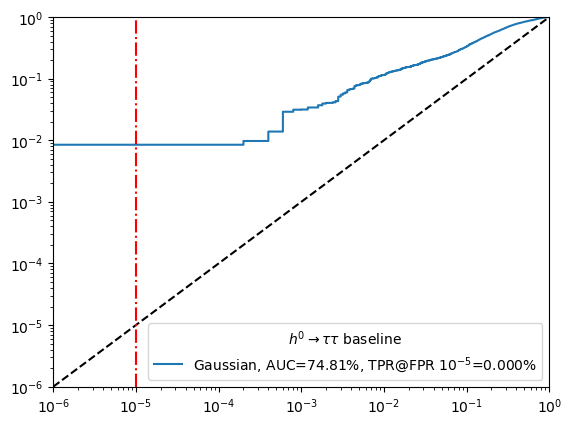

In [10]:
#Start with Gaussian
# background_data_reduced, extraneous = train_test_split(background_data, test_size = 0.5)


X_train_val, X_test = train_test_split(background_data.reshape(background_data.shape[0], -1), test_size=0.2, shuffle=True)
X_train, X_val = train_test_split(X_train_val, test_size=0.2, shuffle=True)
scaler = StandardScaler()
scaler.fit(X_train)
signal_data = signal_data.reshape(signal_data.shape[0], -1)
merged_data = np.concatenate([X_test, signal_data], axis=0)
merged_labels = np.concatenate([np.zeros(X_test.shape[0]), np.ones(signal_data.shape[0])], axis=0)
merged_data_trans = scaler.transform(merged_data)
merged_loss = np.sum(merged_data_trans ** 2, axis=-1)
fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
tpr_1em5 = find_nearest(fpr, 1e-5)

fpr_gaussian = fpr
tpr_gaussian = tpr
tpr_1em5_gaussian = tpr_1em5
auc_gaussian = auc(fpr, tpr)
plt.plot(fpr_gaussian, tpr_gaussian, label=f"Gaussian, AUC={auc(fpr_gaussian, tpr_gaussian)*100:.2f}%, TPR@FPR $10^{{-5}}$={tpr_gaussian[tpr_1em5_gaussian]*100:.3f}%")
plt.legend(title = str(signal_label) +" baseline")
plt.plot([1e-6, 1], [1e-6, 1], 'k--')
plt.plot([1e-5, 1e-5], [1e-6, 1], 'r-.')
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

In [11]:
#Continue with PUMAP
X_train_scaled, pt_scaler = scale_pt(X_train)

X_test_scaled, _ = scale_pt(X_test, pt_scaler)

In [ ]:
(fpr_pumap_two, tpr_pumap_two, tpr_1em5_pumap_two, auc_pumap_two) = PUMAP_ROC(signal_data, 2)
(fpr_pumap_three, tpr_pumap_three, tpr_1em5_pumap_three, auc_pumap_three) = PUMAP_ROC(signal_data, 3)
(fpr_pumap_four, tpr_pumap_four, tpr_1em5_pumap_four, auc_pumap_four) = PUMAP_ROC(signal_data, 4)
(fpr_pumap_five, tpr_pumap_five, tpr_1em5_pumap_five, auc_pumap_five) = PUMAP_ROC(signal_data, 5)
# (fpr_pumap_eight, tpr_pumap_eight, tpr_1em5_pumap_eight, auc_pumap_eight) = PUMAP_ROC(signal_data, 8)
# (fpr_pumap_ten, tpr_pumap_ten, tpr_1em5_pumap_ten, auc_pumap_ten) = PUMAP_ROC(signal_data, 10)

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ParametricUMAP(autoencoder_loss=True, decoder=<Sequential name=sequential_1, built=True>, encoder=<Sequential name=sequential, built=True>, keras_fit_kwargs={'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7fa8da2c4d10>]})
Mon Feb  3 19:20:31 2025 Construct fuzzy simplicial set
Mon Feb  3 19:20:31 2025 Finding Nearest Neighbors
Mon Feb  3 19:20:31 2025 Building RP forest with 11 trees
Mon Feb  3 19:20:34 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Feb  3 19:20:43 2025 Finished Nearest Neighbor Search
Mon Feb  3 19:20:45 2025 Construct embedding
Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1940
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1671
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1617
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1592
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1582
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1574
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1573
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1567
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1560
Epoch 10/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1560
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
Mon Feb  3 19:20:57 2025 Finished embedding


/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle encoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle decoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle keras_fit_kwargs: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle parametric_model: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: 

Mon Feb  3 19:20:59 2025 Worst tree score: 0.93200000
Mon Feb  3 19:20:59 2025 Mean tree score: 0.93573295
Mon Feb  3 19:20:59 2025 Best tree score: 0.94112500
Mon Feb  3 19:21:00 2025 Forward diversification reduced edges from 240000 to 85347
Mon Feb  3 19:21:02 2025 Reverse diversification reduced edges from 85347 to 85347
Mon Feb  3 19:21:04 2025 Degree pruning reduced edges from 83126 to 83126
Mon Feb  3 19:21:04 2025 Resorting data and graph based on tree order
Mon Feb  3 19:21:04 2025 Building and compiling search function
Mon Feb  3 19:21:06 2025 Building and compiling search function


Epochs completed:   0%|            0/6 [00:00]

Starting PUMAP signal embedding: $h^{{0}} \to \tau\tau$
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Epochs completed:   0%|            0/6 [00:00]

Successful PUMAP signal embedding, inverse transform, and loss computations: $h^{{0}} \to \tau\tau$
ParametricUMAP(autoencoder_loss=True, decoder=<Sequential name=sequential_3, built=True>, encoder=<Sequential name=sequential_2, built=True>, keras_fit_kwargs={'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7fa8cd90b190>]})
Mon Feb  3 19:23:58 2025 Construct fuzzy simplicial set
Mon Feb  3 19:23:58 2025 Finding Nearest Neighbors
Mon Feb  3 19:23:58 2025 Building RP forest with 11 trees
Mon Feb  3 19:23:58 2025 NN descent for 14 iterations


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Feb  3 19:23:59 2025 Finished Nearest Neighbor Search
Mon Feb  3 19:23:59 2025 Construct embedding
Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1905
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1654
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1607
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1582
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1576
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1570
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1562
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1558
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1553
Epoch 10/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1550
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
Mon Feb  3 19:24:10 2025 Finished embedding


/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle encoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle decoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle keras_fit_kwargs: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle parametric_model: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: 

Mon Feb  3 19:24:10 2025 Worst tree score: 0.92968750
Mon Feb  3 19:24:10 2025 Mean tree score: 0.93780682
Mon Feb  3 19:24:10 2025 Best tree score: 0.94462500
Mon Feb  3 19:24:10 2025 Forward diversification reduced edges from 240000 to 85358
Mon Feb  3 19:24:10 2025 Reverse diversification reduced edges from 85358 to 85358
Mon Feb  3 19:24:10 2025 Degree pruning reduced edges from 83142 to 83142
Mon Feb  3 19:24:10 2025 Resorting data and graph based on tree order
Mon Feb  3 19:24:11 2025 Building and compiling search function
Mon Feb  3 19:24:12 2025 Building and compiling search function


Epochs completed:   0%|            0/6 [00:00]

Starting PUMAP signal embedding: $h^{{0}} \to \tau\tau$
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Epochs completed:   0%|            0/6 [00:00]

Successful PUMAP signal embedding, inverse transform, and loss computations: $h^{{0}} \to \tau\tau$
ParametricUMAP(autoencoder_loss=True, decoder=<Sequential name=sequential_5, built=True>, encoder=<Sequential name=sequential_4, built=True>, keras_fit_kwargs={'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7fa89c2bfb10>]})
Mon Feb  3 19:29:02 2025 Construct fuzzy simplicial set
Mon Feb  3 19:29:02 2025 Finding Nearest Neighbors
Mon Feb  3 19:29:02 2025 Building RP forest with 11 trees
Mon Feb  3 19:29:02 2025 NN descent for 14 iterations


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Feb  3 19:29:03 2025 Finished Nearest Neighbor Search
Mon Feb  3 19:29:03 2025 Construct embedding
Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1909
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1640
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1592
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1574
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1566
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1560
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1556
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1559
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1551
Epoch 10/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1548
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
Mon Feb  3 19:29:14 2025 Finished embedding


/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle encoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle decoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle keras_fit_kwargs: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle parametric_model: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: 

Mon Feb  3 19:29:15 2025 Worst tree score: 0.93287500
Mon Feb  3 19:29:15 2025 Mean tree score: 0.93752841
Mon Feb  3 19:29:15 2025 Best tree score: 0.94312500
Mon Feb  3 19:29:15 2025 Forward diversification reduced edges from 240000 to 85351
Mon Feb  3 19:29:15 2025 Reverse diversification reduced edges from 85351 to 85351
Mon Feb  3 19:29:15 2025 Degree pruning reduced edges from 83134 to 83134
Mon Feb  3 19:29:15 2025 Resorting data and graph based on tree order
Mon Feb  3 19:29:15 2025 Building and compiling search function
Mon Feb  3 19:29:16 2025 Building and compiling search function


Epochs completed:   0%|            0/6 [00:00]

Starting PUMAP signal embedding: $h^{{0}} \to \tau\tau$
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Epochs completed:   0%|            0/6 [00:00]

Successful PUMAP signal embedding, inverse transform, and loss computations: $h^{{0}} \to \tau\tau$
ParametricUMAP(autoencoder_loss=True, decoder=<Sequential name=sequential_7, built=True>, encoder=<Sequential name=sequential_6, built=True>, keras_fit_kwargs={'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7fa8cdd74d10>]})
Mon Feb  3 19:43:12 2025 Construct fuzzy simplicial set
Mon Feb  3 19:43:12 2025 Finding Nearest Neighbors
Mon Feb  3 19:43:12 2025 Building RP forest with 11 trees
Mon Feb  3 19:43:12 2025 NN descent for 14 iterations


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Feb  3 19:43:13 2025 Finished Nearest Neighbor Search
Mon Feb  3 19:43:13 2025 Construct embedding
Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/layers/layer.py:360: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:588: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1918
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1661
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1605
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1583
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1575
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1567
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1562
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1560
Epoch 9/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1555
Epoch 10/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1557
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
Mon Feb  3 19:43:24 2025 Finished embedding


/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle encoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle decoder: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle keras_fit_kwargs: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: Did not pickle parametric_model: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'
  warn("Did not pickle {}: {}".format(key, e))
/opt/conda/lib/python3.11/site-packages/umap/parametric_umap.py:946: UserWarning: 

Mon Feb  3 19:43:24 2025 Worst tree score: 0.93100000
Mon Feb  3 19:43:24 2025 Mean tree score: 0.93811932
Mon Feb  3 19:43:24 2025 Best tree score: 0.94406250
Mon Feb  3 19:43:25 2025 Forward diversification reduced edges from 240000 to 85350
Mon Feb  3 19:43:25 2025 Reverse diversification reduced edges from 85350 to 85350
Mon Feb  3 19:43:25 2025 Degree pruning reduced edges from 83124 to 83124
Mon Feb  3 19:43:25 2025 Resorting data and graph based on tree order
Mon Feb  3 19:43:25 2025 Building and compiling search function
Mon Feb  3 19:43:26 2025 Building and compiling search function


In [ ]:
plt.clf()

# Add data for plotting
plot_ROC("PUMAP", fpr_pumap_two, tpr_pumap_two, tpr_1em5_pumap_two, 2)
plot_ROC("PUMAP", fpr_pumap_three, tpr_pumap_three, tpr_1em5_pumap_three, 3)
plot_ROC("PUMAP", fpr_pumap_four, tpr_pumap_four, tpr_1em5_pumap_four, 4)
plot_ROC("PUMAP", fpr_pumap_five, tpr_pumap_five, tpr_1em5_pumap_five, 5)
# plot_ROC("PUMAP", fpr_pumap_eight, tpr_pumap_eight, tpr_1em5_pumap_eight, 8)
# plot_ROC("PUMAP", fpr_pumap_ten, tpr_pumap_ten, tpr_1em5_pumap_ten, 10)

# Add lines and set axes limits
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Add legend to the plot
legend = plt.legend(
    title=f"{signal_label} Baseline",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

#Save the plot in a buffer
pumap_roc_buffer = io.BytesIO()
plt.savefig(pumap_roc_buffer, format='png', dpi=300, bbox_inches='tight')
pumap_roc_buffer.seek(0)
plt.close()

In [ ]:
#Save the best PUMAP targets for the ultimate plot
auc_pumap_dict = {}
tpr_1em5_pumap_dict = {}

for i in range(2, 6):
    (fpr_pumap_test, tpr_pumap_test, tpr_1em5_pumap_test, auc_pumap_test) = PUMAP_ROC(signal_data, i)
    auc_pumap_dict[i] = auc_pumap_test
    tpr_1em5_pumap_dict[i] = tpr_1em5_pumap_test

sorted_auc_pumap_dict = dict(sorted(auc_pumap_dict.items(), key=lambda item: item[1], reverse=True))
sorted_tpr_1em5_pumap_dict = dict(sorted(tpr_1em5_pumap_dict.items(), key=lambda item: item[1], reverse=True))

# Print header
print(f"{'PCA Components':<15} {'AUC (%)':<10} {'TPR@FPR 10^{-5} (%)':<10}")
print("-" * 25)

# Print each row
for n_components, auc_val in sorted_auc_pumap_dict.items():
    tpr_1em5 = sorted_tpr_1em5_pumap_dict[n_components]
    print(f"{n_components:<15} {auc_val*100:.2f}% {tpr_1em5*100:.3f}%")
	
k_pumap = max(sorted_auc_pumap_dict, key=sorted_auc_pumap_dict.get)
k_prime_pumap = max(sorted_tpr_1em5_pumap_dict, key=sorted_tpr_1em5_pumap_dict.get)

print(k_pumap)
print(k_prime_pumap)

(fpr_pumap_target, tpr_pumap_target, tpr_1em5_pumap_target, auc_pumap_target) = PUMAP_ROC(signal_data, k_pumap)
(fpr_pumap_target_two, tpr_pumap_target_two, tpr_1em5_pumap_target_two, auc_pumap_target_two) = PUMAP_ROC(signal_data, k_prime_pumap)

In [ ]:

# model = PCA(n_components=10)

# trainEmbedding = model.fit_transform(X_train_scaled)
# inv_transform_training_data = model.inverse_transform(trainEmbedding)

In [ ]:
# background_loss = get_loss_pca(X_train_scaled[:, 1:], inv_transform_training_data[:, 1:])

# plt.figure()

# signal_data = signal_data.reshape(signal_data.shape[0], -1)
# signal_data_scaled, _ = scale_pt(signal_data, pt_scaler)
# merged_labels = np.concatenate(
#     [np.zeros(X_train.shape[0]), np.ones(signal_data.shape[0])], axis=0
# )

# print("Starting PCA signal embedding: " + signal_label)
# inv_transform_signal_data = model.inverse_transform(model.transform(signal_data_scaled))

# signal_loss = get_loss_pca(signal_data_scaled[:, 1:], inv_transform_signal_data[:, 1:])
# merged_loss = np.concatenate([background_loss, signal_loss], axis=0)

# print("Successful PCA signal embedding, inverse transform, and loss computations: " + signal_label)

# fpr, tpr, thresholds = roc_curve(merged_labels, merged_loss)
# tpr_1em5 = find_nearest(fpr, 1e-5)

# fpr_pca = fpr
# tpr_pca = tpr
# tpr_1em5_pca = tpr_1em5
# auc_pca = auc

In [ ]:
X_val_scaled, _ = scale_pt(X_val, pt_scaler)

In [ ]:
(fpr_ae_two, tpr_ae_two, tpr_1em5_ae_two, auc_ae_two) = AE_ROC(signal_data, 2)
(fpr_ae_three, tpr_ae_three, tpr_1em5_ae_three, auc_ae_three) = AE_ROC(signal_data, 3)
(fpr_ae_four, tpr_ae_four, tpr_1em5_ae_four, auc_ae_four) = AE_ROC(signal_data, 4)
(fpr_ae_five, tpr_ae_five, tpr_1em5_ae_five, auc_ae_five) = AE_ROC(signal_data, 5)
# (fpr_ae_eight, tpr_ae_eight, tpr_1em5_ae_eight, auc_ae_eight) = AE_ROC(signal_data, 8)
# (fpr_ae_ten, tpr_ae_ten, tpr_1em5_ae_ten, auc_ae_ten) = AE_ROC(signal_data, 10)

In [ ]:
plt.clf()

# Add data for plotting
plot_ROC("DNNAE", fpr_ae_two, tpr_ae_two, tpr_1em5_ae_two, 2)
plot_ROC("DNNAE", fpr_ae_three, tpr_ae_three, tpr_1em5_ae_three, 3)
plot_ROC("DNNAE", fpr_ae_four, tpr_ae_four, tpr_1em5_ae_four, 4)
plot_ROC("DNNAE", fpr_ae_five, tpr_ae_five, tpr_1em5_ae_five, 5)
# plot_ROC("DNNAE", fpr_ae_eight, tpr_ae_eight, tpr_1em5_ae_eight, 8)
# plot_ROC("DNNAE", fpr_ae_ten, tpr_ae_ten, tpr_1em5_ae_ten, 10)

# Add lines and set axes limits
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Add legend to the plot
legend = plt.legend(
    title=f"{signal_label} Baseline",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

#Save the plot in a buffer
ae_roc_buffer = io.BytesIO()
plt.savefig(ae_roc_buffer, format='png', dpi=300, bbox_inches='tight')
ae_roc_buffer.seek(0)
plt.close()

In [ ]:
#Save the best AE targets for the ultimate plot
auc_ae_dict = {}
tpr_1em5_ae_dict = {}

for i in range(2, 6):
    (fpr_ae_test, tpr_ae_test, tpr_1em5_ae_test, auc_ae_test) = AE_ROC(signal_data, i)
    auc_ae_dict[i] = auc_ae_test
    tpr_1em5_ae_dict[i] = tpr_1em5_ae_test

sorted_auc_ae_dict = dict(sorted(auc_ae_dict.items(), key=lambda item: item[1], reverse=True))
sorted_tpr_1em5_ae_dict = dict(sorted(tpr_1em5_ae_dict.items(), key=lambda item: item[1], reverse=True))

# Print header
print(f"{'PCA Components':<15} {'AUC (%)':<10} {'TPR@FPR 10^{-5} (%)':<10}")
print("-" * 25)

# Print each row
for n_components, auc_val in sorted_auc_ae_dict.items():
    tpr_1em5 = sorted_tpr_1em5_ae_dict[n_components]
    print(f"{n_components:<15} {auc_val*100:.2f}% {tpr_1em5*100:.3f}%")
	
k_ae = max(sorted_auc_ae_dict, key=sorted_auc_ae_dict.get)
k_prime_ae = max(sorted_tpr_1em5_ae_dict, key=sorted_tpr_1em5_ae_dict.get)

print(k_ae)
print(k_prime_ae)

(fpr_ae_target, tpr_ae_target, tpr_1em5_ae_target, auc_ae_target) = AE_ROC(signal_data, k_ae)
(fpr_ae_target_two, tpr_ae_target_two, tpr_1em5_ae_target_two, auc_ae_target_two) = AE_ROC(signal_data, k_prime_ae)

In [ ]:
#VAE Stuff starts here:

In [ ]:
(fpr_vae_two, tpr_vae_two, tpr_1em5_vae_two, auc_vae_two) = VAE_ROC(signal_data, 2)
(fpr_vae_three, tpr_vae_three, tpr_1em5_vae_three, auc_vae_three) = VAE_ROC(signal_data, 3)
(fpr_vae_four, tpr_vae_four, tpr_1em5_vae_four, auc_vae_four) = VAE_ROC(signal_data, 4)
(fpr_vae_five, tpr_vae_five, tpr_1em5_vae_five, auc_vae_five) = VAE_ROC(signal_data, 5)
# (fpr_vae_eight, tpr_vae_eight, tpr_1em5_vae_eight, auc_vae_eight) = VAE_ROC(signal_data, 8)
# (fpr_vae_ten, tpr_vae_ten, tpr_1em5_vae_ten, auc_vae_ten) = VAE_ROC(signal_data, 10)

In [ ]:
plt.clf()

# Add data for plotting
plot_ROC("DNNVAE", fpr_vae_two, tpr_vae_two, tpr_1em5_vae_two, 2)
plot_ROC("DNNVAE", fpr_vae_three, tpr_vae_three, tpr_1em5_vae_three, 3)
plot_ROC("DNNVAE", fpr_vae_four, tpr_vae_four, tpr_1em5_vae_four, 4)
plot_ROC("DNNVAE", fpr_vae_five, tpr_vae_five, tpr_1em5_vae_five, 5)
# plot_ROC("DNNVAE", fpr_vae_eight, tpr_vae_eight, tpr_1em5_vae_eight, 8)
# plot_ROC("DNNVAE", fpr_vae_ten, tpr_vae_ten, tpr_1em5_vae_ten, 10)

# Add lines and set axes limits
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Add legend to the plot
legend = plt.legend(
    title=f"{signal_label} Baseline",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

#Save the plot in a buffer
vae_roc_buffer = io.BytesIO()
plt.savefig(vae_roc_buffer, format='png', dpi=300, bbox_inches='tight')
vae_roc_buffer.seek(0)
plt.close()

In [ ]:
#Save the best VAE targets for the ultimate plot
auc_vae_dict = {}
tpr_1em5_vae_dict = {}

for i in range(2, 6):
    (fpr_vae_test, tpr_vae_test, tpr_1em5_vae_test, auc_vae_test) = VAE_ROC(signal_data, i)
    auc_vae_dict[i] = auc_vae_test
    tpr_1em5_vae_dict[i] = tpr_1em5_vae_test

sorted_auc_vae_dict = dict(sorted(auc_vae_dict.items(), key=lambda item: item[1], reverse=True))
sorted_tpr_1em5_vae_dict = dict(sorted(tpr_1em5_vae_dict.items(), key=lambda item: item[1], reverse=True))

# Print header
print(f"{'PCA Components':<15} {'AUC (%)':<10} {'TPR@FPR 10^{-5} (%)':<10}")
print("-" * 25)

# Print each row
for n_components, auc_val in sorted_auc_vae_dict.items():
    tpr_1em5 = sorted_tpr_1em5_vae_dict[n_components]
    print(f"{n_components:<15} {auc_val*100:.2f}% {tpr_1em5*100:.3f}%")
	
k_vae = max(sorted_auc_vae_dict, key=sorted_auc_vae_dict.get)
k_prime_vae = max(sorted_tpr_1em5_vae_dict, key=sorted_tpr_1em5_vae_dict.get)

print(k_vae)
print(k_prime_vae)

(fpr_vae_target, tpr_vae_target, tpr_1em5_vae_target, auc_vae_target) = VAE_ROC(signal_data, k_vae)
(fpr_vae_target_two, tpr_vae_target_two, tpr_1em5_vae_target_two, auc_vae_target_two) = VAE_ROC(signal_data, k_prime_vae)

In [ ]:
# # Check background_loss
# print("Background Loss: ", np.any(np.isnan(background_loss)), np.any(np.isinf(background_loss)), np.max(background_loss))

# # Check signal_loss
# print("Signal Loss: ", np.any(np.isnan(signal_loss)), np.any(np.isinf(signal_loss)), np.max(signal_loss))

# # Check merged_loss
# print("Merged Loss: ", np.any(np.isnan(merged_loss)), np.any(np.isinf(merged_loss)), np.max(merged_loss))


In [ ]:
(fpr_pca_two, tpr_pca_two, tpr_1em5_pca_two, auc_pca_two) = PCA_ROC(signal_data, 2)
(fpr_pca_three, tpr_pca_three, tpr_1em5_pca_three, auc_pca_three) = PCA_ROC(signal_data, 3)
(fpr_pca_four, tpr_pca_four, tpr_1em5_pca_four, auc_pca_four) = PCA_ROC(signal_data, 4)
(fpr_pca_five, tpr_pca_five, tpr_1em5_pca_five, auc_pca_five) = PCA_ROC(signal_data, 5)
(fpr_pca_eight, tpr_pca_eight, tpr_1em5_pca_eight, auc_pca_eight) = PCA_ROC(signal_data, 8)
(fpr_pca_ten, tpr_pca_ten, tpr_1em5_pca_ten, auc_pca_ten) = PCA_ROC(signal_data, 10)
(fpr_pca_twelve, tpr_pca_twelve, tpr_1em5_pca_twelve, auc_pca_twelve) = PCA_ROC(signal_data, 12)
(fpr_pca_thirteen, tpr_pca_thirteen, tpr_1em5_pca_thirteen, auc_pca_thirteen) = PCA_ROC(signal_data, 13)
(fpr_pca_sixteen, tpr_pca_sixteen, tpr_1em5_pca_sixteen, auc_pca_sixteen) = PCA_ROC(signal_data, 16)
(fpr_pca_thirtytwo, tpr_pca_thirtytwo, tpr_1em5_pca_thirtytwo, auc_pca_thirtytwo) = PCA_ROC(signal_data, 32)
(fpr_pca_sixtyfour, tpr_pca_sixtyfour, tpr_1em5_pca_sixtyfour, auc_pca_sixtyfour) = PCA_ROC(signal_data, 64)
(fpr_pca_seventy, tpr_pca_seventy, tpr_1em5_pca_seventy, auc_pca_seventy) = PCA_ROC(signal_data, 70)
(fpr_pca_seventysix, tpr_pca_seventysix, tpr_1em5_pca_seventysix, auc_pca_seventysix) = PCA_ROC(signal_data, 76)

In [ ]:
plt.clf()

# Add data for plotting
plot_ROC("PCA", fpr_pca_two, tpr_pca_two, tpr_1em5_pca_two, 2)
plot_ROC("PCA", fpr_pca_three, tpr_pca_three, tpr_1em5_pca_three, 3)
plot_ROC("PCA", fpr_pca_four, tpr_pca_four, tpr_1em5_pca_four, 4)
plot_ROC("PCA", fpr_pca_five, tpr_pca_five, tpr_1em5_pca_five, 5)
plot_ROC("PCA", fpr_pca_eight, tpr_pca_eight, tpr_1em5_pca_eight, 8)
plot_ROC("PCA", fpr_pca_ten, tpr_pca_ten, tpr_1em5_pca_ten, 10)
plot_ROC("PCA", fpr_pca_twelve, tpr_pca_twelve, tpr_1em5_pca_twelve, 12)
plot_ROC("PCA", fpr_pca_thirteen, tpr_pca_thirteen, tpr_1em5_pca_thirteen, 13)
plot_ROC("PCA", fpr_pca_sixteen, tpr_pca_sixteen, tpr_1em5_pca_sixteen, 16)
plot_ROC("PCA", fpr_pca_thirtytwo, tpr_pca_thirtytwo, tpr_1em5_pca_thirtytwo, 32)
plot_ROC("PCA", fpr_pca_sixtyfour, tpr_pca_sixtyfour, tpr_1em5_pca_sixtyfour, 64)
plot_ROC("PCA", fpr_pca_seventy, tpr_pca_seventy, tpr_1em5_pca_seventy, 70)
plot_ROC("PCA", fpr_pca_seventysix, tpr_pca_seventysix, tpr_1em5_pca_seventysix, 76)

# Add lines and set axes limits
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Add legend to the plot
legend = plt.legend(
    title=f"{signal_label} Baseline",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

#Save the plot in a buffer
pca_roc_buffer = io.BytesIO()
plt.savefig(pca_roc_buffer, format='png', dpi=300, bbox_inches='tight')
pca_roc_buffer.seek(0)
plt.close()


# Save the main plot without the legend
# file_head = "/tmp/"
# pca_roc_file_name = file_head + f"New-PCA-ROC-Curve-B{random_background_indices.size}-S{random_signal_indices.size}"
# plt.savefig(f"{pca_roc_file_name}.png", format='png', dpi=300, bbox_inches='tight')
# plt.close()
# Save the main plot with buffer

# Create a separate figure for the legend
# fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the figure size
# legend_fig = ax.legend_ = legend  # Use the existing legend
# ax.axis("off")  # Turn off axes for the legend figure

# # Save the legend as a separate image
# legend_file_name = f"{roc_file_name}_legend.png"
# fig.savefig(legend_file_name, format='png', dpi=300, bbox_inches='tight')
# plt.close(fig)

In [ ]:
#Save the best PCA targets for the ultimate plot
auc_pca_dict = {}
tpr_1em5_pca_dict = {}

for i in range(2, 77):
    (fpr_pca_test, tpr_pca_test, tpr_1em5_pca_test, auc_pca_test) = PCA_ROC(signal_data, i)
    auc_pca_dict[i] = auc_pca_test
    tpr_1em5_pca_dict[i] = tpr_1em5_pca_test

sorted_auc_pca_dict = dict(sorted(auc_pca_dict.items(), key=lambda item: item[1], reverse=True))
sorted_tpr_1em5_pca_dict = dict(sorted(tpr_1em5_pca_dict.items(), key=lambda item: item[1], reverse=True))

# Print header
print(f"{'PCA Components':<15} {'AUC (%)':<10} {'TPR@FPR 10^{-5} (%)':<10}")
print("-" * 25)

# Print each row
for n_components, auc_val in sorted_auc_pca_dict.items():
    tpr_1em5 = sorted_tpr_1em5_pca_dict[n_components]
    print(f"{n_components:<15} {auc_val*100:.2f}% {tpr_1em5*100:.3f}%")
	
k_pca = max(sorted_auc_pca_dict, key=sorted_auc_pca_dict.get)
k_prime_pca = max(sorted_tpr_1em5_pca_dict, key=sorted_tpr_1em5_pca_dict.get)

print(k_pca)
print(k_prime_pca)

(fpr_pca_target, tpr_pca_target, tpr_1em5_pca_target, auc_pca_target) = PCA_ROC(signal_data, k_pca)
(fpr_pca_target_two, tpr_pca_target_two, tpr_1em5_pca_target_two, auc_pca_target_two) = PCA_ROC(signal_data, k_prime_pca)

In [ ]:
plt.clf()

plt.figure(figsize=(25, 8))  # Adjust width and height as needed

#Gaussian
plot_ROC("Gaussian", fpr_gaussian, tpr_gaussian, tpr_1em5_gaussian, 76)

#Get PUMAP-2, PUMAP-3, PUMAP-4, PUMAP with max AUC, PUMAP with max TPR@FPR 10^-5

plot_ROC("PUMAP", fpr_pumap_two, tpr_pumap_two, tpr_1em5_pumap_two, 2)
plot_ROC("PUMAP", fpr_pumap_three, tpr_pumap_three, tpr_1em5_pumap_three, 3)
plot_ROC("PUMAP", fpr_pumap_four, tpr_pumap_four, tpr_1em5_pumap_four, 4)
plot_ROC("PUMAP", fpr_pumap_target, tpr_pumap_target, tpr_1em5_pumap_target, k_pumap)
plot_ROC("PUMAP", fpr_pumap_target_two, tpr_pumap_target_two, tpr_1em5_pumap_target_two, k_prime_pumap)

#Get AE-2, AE-3, AE-4, AE with max AUC, AE with max TPR@FPR 10^-5

plot_ROC("AE", fpr_ae_two, tpr_ae_two, tpr_1em5_ae_two, 2)
plot_ROC("AE", fpr_ae_three, tpr_ae_three, tpr_1em5_ae_three, 3)
plot_ROC("AE", fpr_ae_four, tpr_ae_four, tpr_1em5_ae_four, 4)
plot_ROC("AE", fpr_ae_target, tpr_ae_target, tpr_1em5_ae_target, k_ae)
plot_ROC("AE", fpr_ae_target_two, tpr_ae_target_two, tpr_1em5_ae_target_two, k_prime_ae)

#Get VAE-2, VAE-3, VAE-4, VAE with max AUC, VAE with max TPR@FPR 10^-5

plot_ROC("VAE", fpr_vae_two, tpr_vae_two, tpr_1em5_vae_two, 2)
plot_ROC("VAE", fpr_vae_three, tpr_vae_three, tpr_1em5_vae_three, 3)
plot_ROC("VAE", fpr_vae_four, tpr_vae_four, tpr_1em5_vae_four, 4)
plot_ROC("VAE", fpr_vae_target, tpr_vae_target, tpr_1em5_vae_target, k_vae)
plot_ROC("VAE", fpr_vae_target_two, tpr_vae_target_two, tpr_1em5_vae_target_two, k_prime_vae)

#Get PCA-2, PCA-3, PCA-4, PCA with max AUC, PCA with max TPR@FPR 10^-5
plot_ROC("PCA", fpr_pca_two, tpr_pca_two, tpr_1em5_pca_two, 2)
plot_ROC("PCA", fpr_pca_three, tpr_pca_three, tpr_1em5_pca_three, 3)
plot_ROC("PCA", fpr_pca_four, tpr_pca_four, tpr_1em5_pca_four, 4)
plot_ROC("PCA", fpr_pca_target, tpr_pca_target, tpr_1em5_pca_target, k_pca)
plot_ROC("PCA", fpr_pca_target_two, tpr_pca_target_two, tpr_1em5_pca_target_two, k_prime_pca)

# plt.legend(title=f"{signal_label} Baseline")
# plt.plot([1e-6, 1], [1e-6, 1], "k--")
# plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
# plt.xlim([1e-6, 1])
# plt.ylim([1e-6, 1])
# plt.loglog()

# # Adjust layout
# # plt.tight_layout()
# # Add legend to the plot
# legend = plt.legend(
#     title=f"{signal_label} Baseline",
#     bbox_to_anchor=(1.05, 1),
#     loc="upper left",
#     borderaxespad=0.0
# )
# Add lines and set axes limits
plt.plot([1e-6, 1], [1e-6, 1], "k--")
plt.plot([1e-5, 1e-5], [1e-6, 1], "r-.")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.loglog()

# Add legend to the plot
legend = plt.legend(
    title=f"{signal_label} Baseline",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0
)

plt.tight_layout()

# Save the plot
roc_file_name = f"New-ROC-Curve-B{random_background_indices.size}-S{random_signal_indices.size}"
plt.savefig(f"{roc_file_name}.png", format='png', dpi=300)  # High resolution
# Save the plot using buffer
roc_buffer = io.BytesIO()
plt.savefig(roc_buffer, format='png', dpi=300)  # High resolution
roc_buffer.seek(0)
plt.close()  # Close the figure to release memory

In [ ]:
import smtplib
from email.message import EmailMessage
# from pathlib import Path

# Email details
sender_email = "rosachdeva@ucsd.edu"
#receiver_email = "rosachdeva@ucsd.edu"
receiver_emails = ["rosachdeva@ucsd.edu", "mquinnan@ucsd.edu"]  # List of recipients
password = "uuvo esud bmib fvvk"  # Use app-specific password if using Gmail

# Create the email message
msg = EmailMessage()
msg['Subject'] = 'Final ROC Curve Results'
msg['From'] = sender_email
#msg['To'] = receiver_email
msg['To'] = ", ".join(receiver_emails)  # Join multiple emails into a string


# Attach text content
msg.set_content("Please find the final ROC curves attached.")

# Add the ROC curve image
msg.add_attachment(roc_buffer.read(), maintype='image', subtype='png', filename=f"{roc_file_name}.png")
msg.add_attachment(pumap_roc_buffer.read(), maintype='image', subtype='png', filename="pumap_roc_curve.png")
msg.add_attachment(ae_roc_buffer.read(), maintype='image', subtype='png', filename="ae_roc_curve.png")
msg.add_attachment(vae_roc_buffer.read(), maintype='image', subtype='png', filename="vae_roc_curve.png")
msg.add_attachment(pca_roc_buffer.read(), maintype='image', subtype='png', filename="pca_roc_curve.png")
# roc_curve_path = file_head + roc_file_name + ".png"  # Path to the ROC curve image
# pca_roc_curve_path = file_head + pca_roc_file_name + ".png"  # Path to the PCA ROC curve image
# if Path(roc_curve_path).exists():
#    with open(roc_curve_path, 'rb') as img:
#        img_data = img.read()
#        msg.add_attachment(img_data, maintype='image', subtype='png', filename="roc_curve.png")
# else:
#    print(f"Error: {roc_curve_path} not found. Ensure the ROC curve image is saved.")

# if Path(pca_roc_curve_path).exists():
#    with open(pca_roc_curve_path, 'rb') as img:
#        img_data = img.read()
#        msg.add_attachment(img_data, maintype='image', subtype='png', filename="pca_roc_curve.png")
# else:
#    print(f"Error: {roc_curve_path} not found. Ensure the ROC curve image is saved.")



# Send the email
try:
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:  # For Gmail. Use other SMTP servers if needed.
        server.login(sender_email, password)
        server.send_message(msg)
    print("Email sent successfully!")
except Exception as e:
    print(f"Error sending email: {e}")


In [ ]:
# Define the variables for Gaussian ROC Curve
gaussian_roc_variables = {
    'fpr_gaussian': fpr_gaussian,
    'tpr_gaussian': tpr_gaussian,
    'tpr_1em5_gaussian': tpr_1em5_gaussian,
    'auc_gaussian': auc_gaussian
}

# Specify the file name
gaussian_roc_file = "gaussian_roc_variables.pkl"

# Save the variables using pickle
with open(gaussian_roc_file, 'wb') as file:
    pickle.dump(gaussian_roc_variables, file)

print(f"Gaussian ROC variables saved to {gaussian_roc_file}")

In [ ]:
# Define the variables for PUMAP ROC curve
pumap_roc_variables = {
    'fpr_pumap_two': fpr_pumap_two,
    'tpr_pumap_two': tpr_pumap_two,
    'tpr_1em5_pumap_two': tpr_1em5_pumap_two,
    'auc_pumap_two': auc_pumap_two,
    'fpr_pumap_three': fpr_pumap_three,
    'tpr_pumap_three': tpr_pumap_three,
    'tpr_1em5_pumap_three': tpr_1em5_pumap_three,
    'auc_pumap_three': auc_pumap_three,
    'fpr_pumap_four': fpr_pumap_four,
    'tpr_pumap_four': tpr_pumap_four,
    'tpr_1em5_pumap_four': tpr_1em5_pumap_four,
    'auc_pumap_four': auc_pumap_four,
    'fpr_pumap_five': fpr_pumap_five,
    'tpr_pumap_five': tpr_pumap_five,
    'tpr_1em5_pumap_five': tpr_1em5_pumap_five,
    'auc_pumap_five': auc_pumap_five,
    # 'fpr_pumap_eight': fpr_pumap_eight,
    # 'tpr_pumap_eight': tpr_pumap_eight,
    # 'tpr_1em5_pumap_eight': tpr_1em5_pumap_eight,
    # 'auc_pumap_eight': auc_pumap_eight,
    # 'fpr_pumap_ten': fpr_pumap_ten,
    # 'tpr_pumap_ten': tpr_pumap_ten,
    # 'tpr_1em5_pumap_ten': tpr_1em5_pumap_ten,
    # 'auc_pumap_ten': auc_pumap_ten,
}

# Specify the file name
pumap_roc_file = "pumap_roc_variables.pkl"

# Save the variables using pickle
with open(pumap_roc_file, 'wb') as file:
    pickle.dump(pumap_roc_variables, file)

print(f"PUMAP ROC variables saved to {pumap_roc_file}")

In [ ]:
# Define the variables for DNNAE ROC curve
ae_roc_variables = {
    'fpr_ae_two': fpr_ae_two,
    'tpr_ae_two': tpr_ae_two,
    'tpr_1em5_ae_two': tpr_1em5_ae_two,
    'auc_ae_two': auc_ae_two,
    'fpr_ae_three': fpr_ae_three,
    'tpr_ae_three': tpr_ae_three,
    'tpr_1em5_ae_three': tpr_1em5_ae_three,
    'auc_ae_three': auc_ae_three,
    'fpr_ae_four': fpr_ae_four,
    'tpr_ae_four': tpr_ae_four,
    'tpr_1em5_ae_four': tpr_1em5_ae_four,
    'auc_ae_four': auc_ae_four,
    'fpr_ae_five': fpr_ae_five,
    'tpr_ae_five': tpr_ae_five,
    'tpr_1em5_ae_five': tpr_1em5_ae_five,
    'auc_ae_five': auc_ae_five,
    # 'fpr_ae_eight': fpr_ae_eight,
    # 'tpr_ae_eight': tpr_ae_eight,
    # 'tpr_1em5_ae_eight': tpr_1em5_ae_eight,
    # 'auc_ae_eight': auc_ae_eight,
    # 'fpr_ae_ten': fpr_ae_ten,
    # 'tpr_ae_ten': tpr_ae_ten,
    # 'tpr_1em5_ae_ten': tpr_1em5_ae_ten,
    # 'auc_ae_ten': auc_ae_ten,
}

# Specify the file name
ae_roc_file = "ae_roc_variables.pkl"

# Save the variables using pickle
with open(ae_roc_file, 'wb') as file:
    pickle.dump(ae_roc_variables, file)

print(f"DNNAE ROC variables saved to {ae_roc_file}")

In [ ]:
# Define the variables for DNNVAE ROC curve
vae_roc_variables = {
    'fpr_vae_two': fpr_vae_two,
    'tpr_vae_two': tpr_vae_two,
    'tpr_1em5_vae_two': tpr_1em5_vae_two,
    'auc_vae_two': auc_vae_two,
    'fpr_vae_three': fpr_vae_three,
    'tpr_vae_three': tpr_vae_three,
    'tpr_1em5_vae_three': tpr_1em5_vae_three,
    'auc_vae_three': auc_vae_three,
    'fpr_vae_four': fpr_vae_four,
    'tpr_vae_four': tpr_vae_four,
    'tpr_1em5_vae_four': tpr_1em5_vae_four,
    'auc_vae_four': auc_vae_four,
    'fpr_vae_five': fpr_vae_five,
    'tpr_vae_five': tpr_vae_five,
    'tpr_1em5_vae_five': tpr_1em5_vae_five,
    'auc_vae_five': auc_vae_five,
    # 'fpr_vae_eight': fpr_vae_eight,
    # 'tpr_vae_eight': tpr_vae_eight,
    # 'tpr_1em5_vae_eight': tpr_1em5_vae_eight,
    # 'auc_vae_eight': auc_vae_eight,
    # 'fpr_vae_ten': fpr_vae_ten,
    # 'tpr_vae_ten': tpr_vae_ten,
    # 'tpr_1em5_vae_ten': tpr_1em5_vae_ten,
    # 'auc_vae_ten': auc_vae_ten,
}

# Specify the file name
vae_roc_file = "vae_roc_variables.pkl"

# Save the variables using pickle
with open(vae_roc_file, 'wb') as file:
    pickle.dump(vae_roc_variables, file)

print(f"DNNVAE ROC variables saved to {vae_roc_file}")

In [ ]:
# Define the variables for PCA ROC curve
pca_roc_variables = {
    'fpr_pca_two': fpr_pca_two,
    'tpr_pca_two': tpr_pca_two,
    'tpr_1em5_pca_two': tpr_1em5_pca_two,
    'auc_pca_two': auc_pca_two,
    'fpr_pca_three': fpr_pca_three,
    'tpr_pca_three': tpr_pca_three,
    'tpr_1em5_pca_three': tpr_1em5_pca_three,
    'auc_pca_three': auc_pca_three,
    'fpr_pca_four': fpr_pca_four,
    'tpr_pca_four': tpr_pca_four,
    'tpr_1em5_pca_four': tpr_1em5_pca_four,
    'auc_pca_four': auc_pca_four,
    'fpr_pca_five': fpr_pca_five,
    'tpr_pca_five': tpr_pca_five,
    'tpr_1em5_pca_five': tpr_1em5_pca_five,
    'auc_pca_five': auc_pca_five,
    'fpr_pca_eight': fpr_pca_eight,
    'tpr_pca_eight': tpr_pca_eight,
    'tpr_1em5_pca_eight': tpr_1em5_pca_eight,
    'auc_pca_eight': auc_pca_eight,
    'fpr_pca_ten': fpr_pca_ten,
    'tpr_pca_ten': tpr_pca_ten,
    'tpr_1em5_pca_ten': tpr_1em5_pca_ten,
    'auc_pca_ten': auc_pca_ten,
    'fpr_pca_twelve': fpr_pca_twelve,
    'tpr_pca_twelve': tpr_pca_twelve,
    'tpr_1em5_pca_twelve': tpr_1em5_pca_twelve,
    'auc_pca_twelve': auc_pca_twelve,
    'fpr_pca_thirteen': fpr_pca_thirteen,
    'tpr_pca_thirteen': tpr_pca_thirteen,
    'tpr_1em5_pca_thirteen': tpr_1em5_pca_thirteen,
    'auc_pca_thirteen': auc_pca_thirteen,
    'fpr_pca_sixteen': fpr_pca_sixteen,
    'tpr_pca_sixteen': tpr_pca_sixteen,
    'tpr_1em5_pca_sixteen': tpr_1em5_pca_sixteen,
    'auc_pca_sixteen': auc_pca_sixteen,
    'fpr_pca_thirtytwo': fpr_pca_thirtytwo,
    'tpr_pca_thirtytwo': tpr_pca_thirtytwo,
    'tpr_1em5_pca_thirtytwo': tpr_1em5_pca_thirtytwo,
    'auc_pca_thirtytwo': auc_pca_thirtytwo,
    'fpr_pca_sixtyfour': fpr_pca_sixtyfour,
    'tpr_pca_sixtyfour': tpr_pca_sixtyfour,
    'tpr_1em5_pca_sixtyfour': tpr_1em5_pca_sixtyfour,
    'auc_pca_sixtyfour': auc_pca_sixtyfour,
    'fpr_pca_seventy': fpr_pca_seventy,
    'tpr_pca_seventy': tpr_pca_seventy,
    'tpr_1em5_pca_seventy': tpr_1em5_pca_seventy,
    'auc_pca_seventy': auc_pca_seventy,
    'fpr_pca_seventysix': fpr_pca_seventysix,
    'tpr_pca_seventysix': tpr_pca_seventysix,
    'tpr_1em5_pca_seventysix': tpr_1em5_pca_seventysix,
    'auc_pca_seventysix': auc_pca_seventysix
}

# Specify the file name
pca_roc_file = "pca_roc_variables.pkl"

# Save the variables using pickle
with open(pca_roc_file, 'wb') as file:
    pickle.dump(pca_roc_variables, file)

print(f"PCA ROC variables saved to {pca_roc_file}")

In [ ]:
# Define the variables for the standard ROC curve
roc_variables = {
    'fpr_gaussian': fpr_gaussian,
    'tpr_gaussian': tpr_gaussian,
    'tpr_1em5_gaussian': tpr_1em5_gaussian,
    'auc_gaussian': auc_gaussian,
    'fpr_pumap_two': fpr_pumap_two,
    'tpr_pumap_two': tpr_pumap_two,
    'tpr_1em5_pumap_two': tpr_1em5_pumap_two,
    'auc_pumap_two': auc_pumap_two,
    'fpr_pumap_three': fpr_pumap_three,
    'tpr_pumap_three': tpr_pumap_three,
    'tpr_1em5_pumap_three': tpr_1em5_pumap_three,
    'auc_pumap_three': auc_pumap_three,
    'fpr_pumap_four': fpr_pumap_four,
    'tpr_pumap_four': tpr_pumap_four,
    'tpr_1em5_pumap_four': tpr_1em5_pumap_four,
    'auc_pumap_four': auc_pumap_four,
    'fpr_pumap_target': fpr_pumap_target,
    'tpr_pumap_target': tpr_pumap_target,
    'tpr_1em5_pumap_target': tpr_1em5_pumap_target,
    'auc_pumap_target': auc_pumap_target,
    'k_pumap': k_pumap,
    'fpr_pumap_target_two': fpr_pumap_target_two,
    'tpr_pumap_target_two': tpr_pumap_target_two,
    'tpr_1em5_pumap_target_two': tpr_1em5_pumap_target_two,
    'auc_pumap_target_two': auc_pumap_target_two,
    'k_prime_pumap': k_prime_pumap,
    'fpr_ae_two': fpr_ae_two,
    'tpr_ae_two': tpr_ae_two,
    'tpr_1em5_ae_two': tpr_1em5_ae_two,
    'auc_ae_two': auc_ae_two,
    'fpr_ae_three': fpr_ae_three,
    'tpr_ae_three': tpr_ae_three,
    'tpr_1em5_ae_three': tpr_1em5_ae_three,
    'auc_ae_three': auc_ae_three,
    'fpr_ae_four': fpr_ae_four,
    'tpr_ae_four': tpr_ae_four,
    'tpr_1em5_ae_four': tpr_1em5_ae_four,
    'auc_ae_four': auc_ae_four,
    'fpr_ae_target': fpr_ae_target,
    'tpr_ae_target': tpr_ae_target,
    'tpr_1em5_ae_target': tpr_1em5_ae_target,
    'auc_ae_target': auc_ae_target,
    'k_ae': k_ae,
    'fpr_ae_target_two': fpr_ae_target_two,
    'tpr_ae_target_two': tpr_ae_target_two,
    'tpr_1em5_ae_target_two': tpr_1em5_ae_target_two,
    'auc_ae_target_two': auc_ae_target_two,
    'k_prime_ae': k_prime_ae,
    'fpr_vae_two': fpr_vae_two,
    'tpr_vae_two': tpr_vae_two,
    'tpr_1em5_vae_two': tpr_1em5_vae_two,
    'auc_vae_two': auc_vae_two,
    'fpr_vae_three': fpr_vae_three,
    'tpr_vae_three': tpr_vae_three,
    'tpr_1em5_vae_three': tpr_1em5_vae_three,
    'auc_vae_three': auc_vae_three,
    'fpr_vae_four': fpr_vae_four,
    'tpr_vae_four': tpr_vae_four,
    'tpr_1em5_vae_four': tpr_1em5_vae_four,
    'auc_vae_four': auc_vae_four,
    'fpr_vae_target': fpr_vae_target,
    'tpr_vae_target': tpr_vae_target,
    'tpr_1em5_vae_target': tpr_1em5_vae_target,
    'auc_vae_target': auc_vae_target,
    'k_vae': k_vae,
    'fpr_vae_target_two': fpr_vae_target_two,
    'tpr_vae_target_two': tpr_vae_target_two,
    'tpr_1em5_vae_target_two': tpr_1em5_vae_target_two,
    'auc_vae_target_two': auc_vae_target_two,
    'k_prime_vae': k_prime_vae,
    'fpr_pca_two': fpr_pca_two,
    'tpr_pca_two': tpr_pca_two,
    'tpr_1em5_pca_two': tpr_1em5_pca_two,
    'auc_pca_two': auc_pca_two,
    'fpr_pca_three': fpr_pca_three,
    'tpr_pca_three': tpr_pca_three,
    'tpr_1em5_pca_three': tpr_1em5_pca_three,
    'auc_pca_three': auc_pca_three,
    'fpr_pca_four': fpr_pca_four,
    'tpr_pca_four': tpr_pca_four,
    'tpr_1em5_pca_four': tpr_1em5_pca_four,
    'auc_pca_four': auc_pca_four,
    'fpr_pca_target': fpr_pca_target,
    'tpr_pca_target': tpr_pca_target,
    'tpr_1em5_pca_target': tpr_1em5_pca_target,
    'auc_pca_target': auc_pca_target,
    'k_pca': k_pca,
    'fpr_pca_target_two': fpr_pca_target_two,
    'tpr_pca_target_two': tpr_pca_target_two,
    'tpr_1em5_pca_target_two': tpr_1em5_pca_target_two,
    'auc_pca_target_two': auc_pca_target_two,
    'k_prime_pca': k_prime_pca,
}

roc_file = "roc_variables.pkl"
# Save variables to a file
with open(roc_file, "wb") as file:
    pickle.dump(roc_variables, file)

print(f"ROC variables saved to {roc_file}")

In [ ]:
# Save the requirements.txt
try:
   with open("requirements.txt", "w") as f:
       subprocess.run(["pip", "freeze"], stdout=f, check=True)
   print("requirements.txt saved successfully!")
except Exception as e:
   print(f"An error occurred: {e}")